In [ ]:
import pandas as pd
import numpy as np

# 시각화


1. 집계 환자 수가 n명 이었던 날, 평균 특성 값의 선형 그래프

<Figure size 432x288 with 0 Axes>

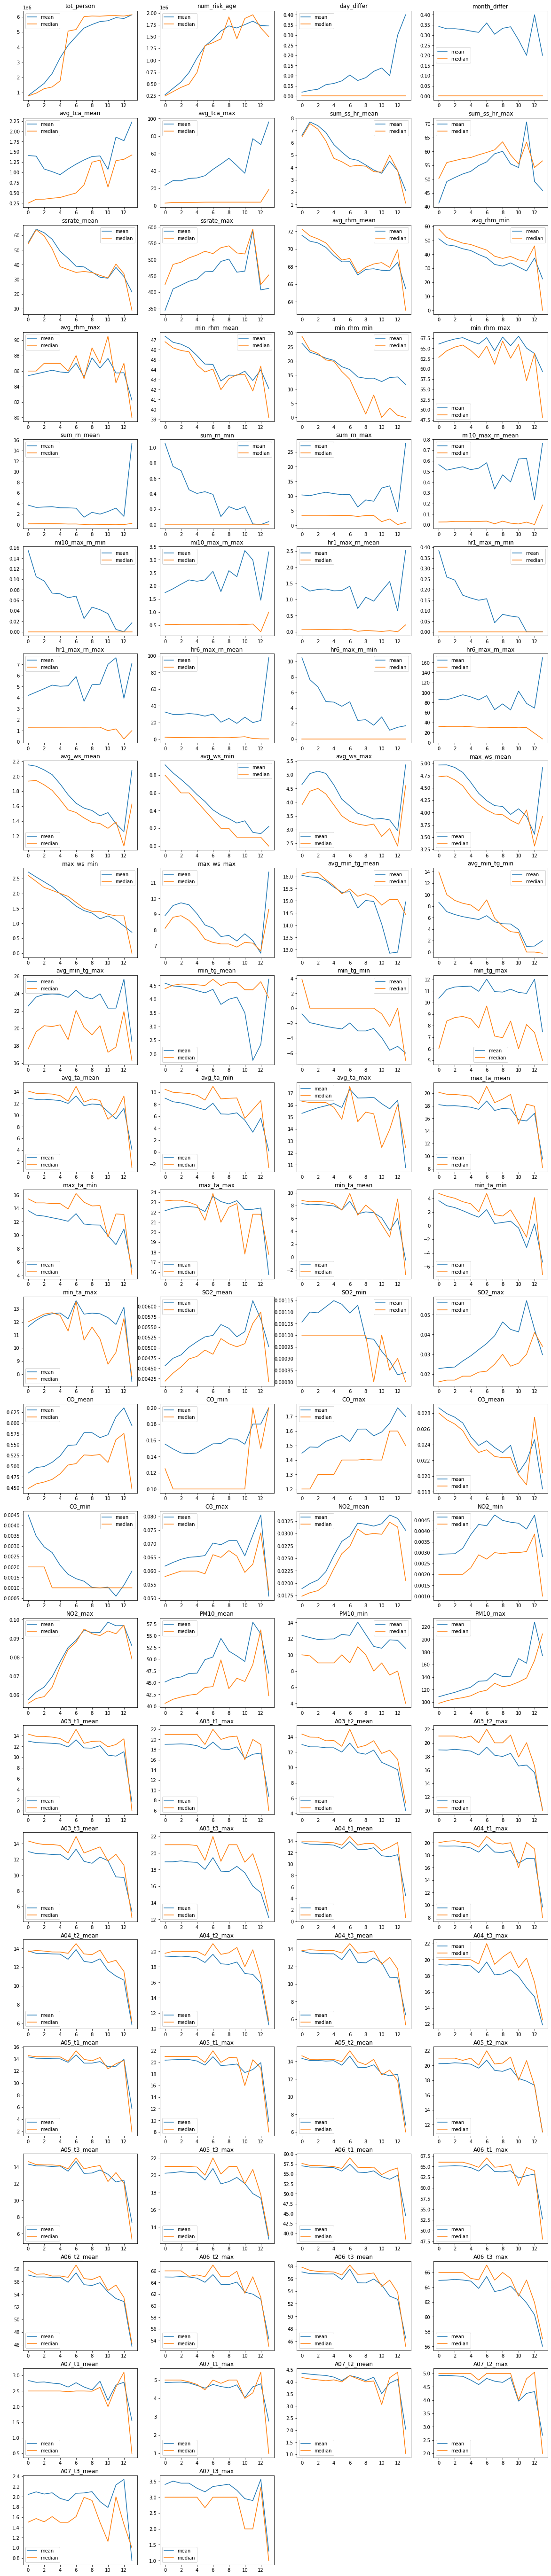

In [ ]:
final = pd.read_csv('/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/final/final_res.csv',encoding='cp949')
df = final[final['year'] != 2016]

the_day_1 = df.groupby(['frequency'],as_index = False)[df.columns[4:]].mean() # 평균, ['yyyymmdd', 'area', 'sex', 'frequency'] 제외
the_day_1.drop(['year','month','day'],axis=1,inplace=True)  # ['year','month','day'] 제외

the_day_2 = df.groupby(['frequency'],as_index = False)[df.columns[4:]].median() # 중위값
the_day_2.drop(['year','month','day'],axis=1,inplace=True) 

import matplotlib.pyplot as plt

grid_col = 4
grid_row = 24

# 위쪽 margin을 20로 늘리고 수직 간격을 15로 늘립니다
plt.subplots_adjust(top=40, hspace=20)
# 아래쪽 margin을 15로 늘립니다
plt.subplots_adjust(bottom=15)

plt.figure(figsize=(20, 100))

x = list(the_day_1['frequency'])
for column,idx in zip(the_day_1.columns[1:],range(len(the_day_1.columns[1:]))):
  y_1 = list(the_day_1[column])
  y_2 = list(the_day_2[column])
  plt.subplot(grid_row,grid_col,idx+1)
  plt.plot(x,y_1)
  plt.plot(x,y_2)
  plt.legend(['mean', 'median'])

  plt.title(column)
plt.show()


# df[target].value_counts()
# 0.0     18197
# 1.0     13513
# 2.0      8231
# 3.0      4467
# 4.0      2321
# 5.0      1347
# 6.0       756
# 7.0       395
# 8.0       222
# 9.0       132
# 10.0       58
# 11.0       20
# 12.0       10
# 13.0        5

# 환자수가 11명 이상일 때 평균 특성 값이 자꾸 튀는 이유는 표본갯수가 적기 때문인고?
# 그럼 최대한 안튀고 선형처럼 보이는 특성들만 취하면 조금 더 나아지나?

# 모델링(catboost)

In [ ]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import RobustScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import StratifiedKFold, KFold
import random
random.seed(42)
np.random.seed(42)

# 모델 평가 지표 
def RMSE(true, pred):
    score = np.sqrt(np.mean(np.square(true-pred)))
    return score

In [ ]:
final = pd.read_csv('/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/final/final_res.csv',encoding='cp949')
final['risk_ratio'] = final['num_risk_age'] / final['tot_person']   # 위험인구 비율
final['day_diff'] = final['max_ta_mean'] - final['min_ta_mean']     # 일교차 
final['temp_humi'] = final['avg_rhm_mean'] * final['avg_ta_mean']   # 습도 * 기온
final['temp_threshold'] = np.where((final['min_ta_mean'] < -1.5), 1, 0)  # 뇌졸중 영향 온도 threshhold
final['diff_risk'] = np.where(final['day_diff'] >= 10, 1, 0)                     # 일교차 10도 이상 


final = final[['yyyymmdd', 'area', 'sex', 'frequency', 'tot_person', 'num_risk_age',
'year', 'month', 'day', 'day_differ','sum_ss_hr_mean','ssrate_mean',
'avg_rhm_mean','avg_rhm_min','min_rhm_mean','sum_rn_min','hr6_max_rn_min','avg_ws_min','max_ws_min','min_tg_min','min_ta_min',
'CO_min','CO_max','SO2_max','NO2_mean', 'A03_t1_mean','A03_t1_max','A03_t2_mean','A03_t2_max',
'A03_t3_mean','A03_t3_max','A04_t1_mean','A04_t1_max','A04_t2_mean','A04_t2_max','A04_t3_mean',
'A04_t3_max','A05_t1_mean','A05_t1_max','A05_t2_mean','A05_t2_max','A05_t3_mean','A05_t3_max',
'A06_t1_mean','A06_t1_max','A06_t2_mean','A06_t2_max','A06_t3_mean','A06_t3_max','A07_t1_mean',
'A07_t1_max','A07_t2_mean','A07_t2_max','risk_ratio', 'temp_humi', 'temp_threshold', 'day_diff', 'diff_risk', 'avg_min_tg_min']
]

for col in list(final.columns):
  if final[col].dtype == 'float64':
    final[col] = final[col].astype('int', errors='ignore') 

# train, test split
train = final[final['year'] != 2016].drop('yyyymmdd', axis=1)
test = final[final['year'] == 2016].drop(['frequency', 'yyyymmdd'], axis=1)

X = train.drop('frequency', axis=1)
y = train['frequency']

from sklearn.model_selection import train_test_split,StratifiedKFold, KFold
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42, stratify=X['month'])

# 모델링 
from catboost import CatBoostRegressor

CAT = CatBoostRegressor(verbose=2, random_state=42, one_hot_max_size = 17)
CAT.fit(X_train, y_train,
        cat_features=['area', 'sex', 'year', 'month', 'day', 'day_differ', 
                      'temp_threshold', 'diff_risk'],
        eval_set=(X_val, y_val),
        early_stopping_rounds = 300, use_best_model = True)


from tqdm import tqdm
CAT = CatBoostRegressor(verbose=1, random_seed=42, cat_features=['area', 'sex', 'year', 'month', 'day', 'day_differ', 
                      'temp_threshold', 'diff_risk'], one_hot_max_size = 17)

# K-Fold 
def kfold(model, tr):
    cv_accuracy = []
    cv = KFold(n_splits = 5, shuffle=True, random_state=42)
    n_iter = 0

    for t,v in tqdm(cv.split(tr, tr['frequency'])): 
        train_cv = tr.iloc[t]
        val_cv = tr.iloc[v]

        X = train_cv.drop('frequency', axis=1)
        y = train_cv['frequency']

        val_X = val_cv.drop('frequency', axis=1)
        val_y = val_cv['frequency']

        model.fit(X, y, eval_set = [(val_X, val_y)],
                  early_stopping_rounds=200, verbose=False, use_best_model = True)
        score = RMSE(val_y, model.predict(val_X))

        cv_accuracy.append(score)
        n_iter += 1
    
    return np.mean(cv_accuracy)
print(kfold(CAT, train))

Learning rate set to 0.090776
0:	learn: 1.6124288	test: 1.6141786	best: 1.6141786 (0)	total: 35.5ms	remaining: 35.5s
2:	learn: 1.5148113	test: 1.5167755	best: 1.5167755 (2)	total: 92ms	remaining: 30.6s
4:	learn: 1.4411348	test: 1.4436779	best: 1.4436779 (4)	total: 146ms	remaining: 29.1s
6:	learn: 1.3869756	test: 1.3902253	best: 1.3902253 (6)	total: 194ms	remaining: 27.6s
8:	learn: 1.3496756	test: 1.3538359	best: 1.3538359 (8)	total: 248ms	remaining: 27.3s
10:	learn: 1.3211440	test: 1.3261404	best: 1.3261404 (10)	total: 299ms	remaining: 26.9s
12:	learn: 1.2987927	test: 1.3045283	best: 1.3045283 (12)	total: 360ms	remaining: 27.4s
14:	learn: 1.2820920	test: 1.2885509	best: 1.2885509 (14)	total: 412ms	remaining: 27.1s
16:	learn: 1.2716822	test: 1.2790997	best: 1.2790997 (16)	total: 476ms	remaining: 27.5s
18:	learn: 1.2636196	test: 1.2718629	best: 1.2718629 (18)	total: 534ms	remaining: 27.5s
20:	learn: 1.2567121	test: 1.2659368	best: 1.2659368 (20)	total: 582ms	remaining: 27.1s
22:	learn: 1

5it [01:24, 16.92s/it]

1.2359157068733078


In [ ]:
# ○ 1차

# 결과 : 1.2361198195820258
	
# 사용한 특성: 
# ['yyyymmdd', 'area', 'sex', 'frequency', 'tot_person', 'num_risk_age',
# 'year', 'month', 'day', 'day_differ','avg_tca_max','sum_ss_hr_mean','ssrate_mean',
# 'avg_rhm_mean','avg_rhm_min','min_rhm_mean','min_rhm_min','sum_rn_min','mi10_max_rn_min',
# 'hr1_max_rn_min','hr6_max_rn_min','avg_ws_min','max_ws_min','min_tg_min','min_ta_min','SO2_min',
# 'CO_min','CO_max','O3_min','NO2_mean', 'A03_t1_mean','A03_t1_max','A03_t2_mean','A03_t2_max',
# 'A03_t3_mean','A03_t3_max','A04_t1_mean','A04_t1_max','A04_t2_mean','A04_t2_max','A04_t3_mean',
# 'A04_t3_max','A05_t1_mean','A05_t1_max','A05_t2_mean','A05_t2_max','A05_t3_mean','A05_t3_max',
# 'A06_t1_mean','A06_t1_max','A06_t2_mean','A06_t2_max','A06_t3_mean','A06_t3_max','A07_t1_mean',
# 'A07_t1_max','A07_t2_mean','A07_t2_max','A07_t3_mean','A07_t3_max','risk_ratio', 'temp_humi', 'temp_threshold', 'day_diff', 'diff_risk']

# 누락한 특성:
# ['month_differ','avg_tca_mean','sum_ss_hr_max','ssrate_max','avg_rhm_max','min_rhm_max',
# 'sum_rn_mean','sum_rn_max','mi10_max_rn_mean','mi10_max_rn_max','hr1_max_rn_mean',
# 'hr1_max_rn_max','hr6_max_rn_mean','hr6_max_rn_max','avg_ws_mean','avg_ws_max','max_ws_mean',
# 'max_ws_max','avg_min_tg_mean','avg_min_tg_min','avg_min_tg_max','min_tg_mean','min_tg_max',
# 'avg_ta_mean','avg_ta_min','avg_ta_max','max_ta_mean','max_ta_min','max_ta_max','min_ta_mean',
# 'min_ta_max','SO2_mean','SO2_max','CO_mean','O3_mean','O3_max','NO2_min','NO2_max','PM10_mean',
# 'PM10_min','PM10_max']

# ======================================================================================================
# ○ 2차

# 결과 : 1.23668011129542

# 사용한 특성: 
# ['yyyymmdd', 'area', 'sex', 'frequency', 'tot_person', 'num_risk_age',
# 'year', 'month', 'day', 'day_differ','avg_tca_max','sum_ss_hr_mean','ssrate_mean',
# 'avg_rhm_mean','avg_rhm_min','min_rhm_mean','min_rhm_min','sum_rn_min','mi10_max_rn_min',
# 'hr1_max_rn_min','hr6_max_rn_min','avg_ws_min','max_ws_min','min_tg_min','min_ta_min','SO2_min',
# 'CO_min','CO_max','O3_min','NO2_mean', 'A03_t1_mean','A03_t1_max','A03_t2_mean','A03_t2_max',
# 'A03_t3_mean','A03_t3_max','A04_t1_mean','A04_t1_max','A04_t2_mean','A04_t2_max','A04_t3_mean',
# 'A04_t3_max','A05_t1_mean','A05_t1_max','A05_t2_mean','A05_t2_max','A05_t3_mean','A05_t3_max',
# 'A06_t1_mean','A06_t1_max','A06_t2_mean','A06_t2_max','A06_t3_mean','A06_t3_max','A07_t1_mean',
# 'A07_t1_max','A07_t2_mean','A07_t2_max','A07_t3_mean','A07_t3_max','risk_ratio', 'temp_humi', 'temp_threshold', 'day_diff', 'diff_risk'
# ,'avg_min_tg_min','SO2_max','PM10_max']

# ======================================================================================================
# ○ 3차

# 결과 : 1.2365189615989953

# 사용한 특성: 
# ['yyyymmdd', 'area', 'sex', 'frequency', 'tot_person', 'num_risk_age',
# 'year', 'month', 'day', 'day_differ','avg_tca_max','sum_ss_hr_mean','ssrate_mean',
# 'avg_rhm_mean','avg_rhm_min','min_rhm_mean','min_rhm_min','sum_rn_min','mi10_max_rn_min',
# 'hr1_max_rn_min','hr6_max_rn_min','avg_ws_min','max_ws_min','min_tg_min','min_ta_min','SO2_min',
# 'CO_min','CO_max','O3_min','NO2_mean', 'A03_t1_mean','A03_t1_max','A03_t2_mean','A03_t2_max',
# 'A03_t3_mean','A03_t3_max','A04_t1_mean','A04_t1_max','A04_t2_mean','A04_t2_max','A04_t3_mean',
# 'A04_t3_max','A05_t1_mean','A05_t1_max','A05_t2_mean','A05_t2_max','A05_t3_mean','A05_t3_max',
# 'A06_t1_mean','A06_t1_max','A06_t2_mean','A06_t2_max','A06_t3_mean','A06_t3_max','A07_t1_mean',
# 'A07_t1_max','A07_t2_mean','A07_t2_max','A07_t3_mean','A07_t3_max','risk_ratio', 'temp_humi', 'temp_threshold', 'day_diff', 'diff_risk'
# ,'avg_min_tg_min']

# ======================================================================================================
# ○ 4차

# 결과 : 1.2361198195820258

# 사용한 특성: 
# ['yyyymmdd', 'area', 'sex', 'frequency', 'tot_person', 'num_risk_age',
# 'year', 'month', 'day', 'day_differ','avg_tca_max','sum_ss_hr_mean','ssrate_mean',
# 'avg_rhm_mean','avg_rhm_min','min_rhm_mean','min_rhm_min','sum_rn_min','mi10_max_rn_min',
# 'hr1_max_rn_min','hr6_max_rn_min','avg_ws_min','max_ws_min','min_tg_min','min_ta_min','SO2_min',
# 'CO_min','CO_max','O3_min','NO2_mean', 'A03_t1_mean','A03_t1_max','A03_t2_mean','A03_t2_max',
# 'A03_t3_mean','A03_t3_max','A04_t1_mean','A04_t1_max','A04_t2_mean','A04_t2_max','A04_t3_mean',
# 'A04_t3_max','A05_t1_mean','A05_t1_max','A05_t2_mean','A05_t2_max','A05_t3_mean','A05_t3_max',
# 'A06_t1_mean','A06_t1_max','A06_t2_mean','A06_t2_max','A06_t3_mean','A06_t3_max','A07_t1_mean',
# 'A07_t1_max','A07_t2_mean','A07_t2_max','A07_t3_mean','A07_t3_max','risk_ratio', 'temp_humi', 'temp_threshold', 'day_diff', 'diff_risk'
# ,'SO2_max']

# ======================================================================================================
# ○ 5차

# 결과 : 1.2367202743767787

# 사용한 특성: 
# ['yyyymmdd', 'area', 'sex', 'frequency', 'tot_person', 'num_risk_age',
# 'year', 'month', 'day', 'day_differ','avg_tca_max','sum_ss_hr_mean','ssrate_mean',
# 'avg_rhm_mean','avg_rhm_min','min_rhm_mean','min_rhm_min','sum_rn_min','mi10_max_rn_min',
# 'hr1_max_rn_min','hr6_max_rn_min','avg_ws_min','max_ws_min','min_tg_min','min_ta_min','SO2_min',
# 'CO_min','CO_max','O3_min','NO2_mean', 'A03_t1_mean','A03_t1_max','A03_t2_mean','A03_t2_max',
# 'A03_t3_mean','A03_t3_max','A04_t1_mean','A04_t1_max','A04_t2_mean','A04_t2_max','A04_t3_mean',
# 'A04_t3_max','A05_t1_mean','A05_t1_max','A05_t2_mean','A05_t2_max','A05_t3_mean','A05_t3_max',
# 'A06_t1_mean','A06_t1_max','A06_t2_mean','A06_t2_max','A06_t3_mean','A06_t3_max','A07_t1_mean',
# 'A07_t1_max','A07_t2_mean','A07_t2_max','A07_t3_mean','A07_t3_max','risk_ratio', 'temp_humi', 'temp_threshold', 'day_diff', 'diff_risk'
# ,'PM10_max']

# ======================================================================================================
# ○ 6차

# 결과 : 1.2369474125475592

# 사용한 특성: 
# ['yyyymmdd', 'area', 'sex', 'frequency', 'tot_person', 'num_risk_age',
# 'year', 'month', 'day', 'day_differ','avg_tca_max','sum_ss_hr_mean','ssrate_mean',
# 'avg_rhm_mean','avg_rhm_min','min_rhm_mean','min_rhm_min','sum_rn_min','mi10_max_rn_min',
# 'hr1_max_rn_min','hr6_max_rn_min','avg_ws_min','max_ws_min','min_tg_min','min_ta_min','SO2_min',
# 'CO_min','CO_max','O3_min','NO2_mean', 'A03_t1_mean','A03_t1_max','A03_t2_mean','A03_t2_max',
# 'A03_t3_mean','A03_t3_max','A04_t1_mean','A04_t1_max','A04_t2_mean','A04_t2_max','A04_t3_mean',
# 'A04_t3_max','A05_t1_mean','A05_t1_max','A05_t2_mean','A05_t2_max','A05_t3_mean','A05_t3_max',
# 'A06_t1_mean','A06_t1_max','A06_t2_mean','A06_t2_max','A06_t3_mean','A06_t3_max','A07_t1_mean',
# 'A07_t1_max','A07_t2_mean','A07_t2_max','A07_t3_mean','A07_t3_max','risk_ratio', 'temp_humi', 'temp_threshold', 'day_diff', 'diff_risk'
# ,'PM10_max', 'avg_min_tg_min']

# ======================================================================================================
# ○ 7차

# 결과 : 1.2365833657272927
	
# 사용한 특성: 
# ['yyyymmdd', 'area', 'sex', 'frequency', 'tot_person', 'num_risk_age',
# 'year', 'month', 'day', 'day_differ','avg_tca_max','sum_ss_hr_mean','ssrate_mean',
# 'avg_rhm_mean','avg_rhm_min','min_rhm_mean','min_rhm_min','sum_rn_min','mi10_max_rn_min',
# 'hr1_max_rn_min','hr6_max_rn_min','avg_ws_min','max_ws_min','min_tg_min','min_ta_min','SO2_min',
# 'CO_min','CO_max','O3_min','NO2_mean', 'A03_t1_mean','A03_t1_max','A03_t2_mean','A03_t2_max',
# 'A03_t3_mean','A03_t3_max','A04_t1_mean','A04_t1_max','A04_t2_mean','A04_t2_max','A04_t3_mean',
# 'A04_t3_max','A05_t1_mean','A05_t1_max','A05_t2_mean','A05_t2_max','A05_t3_mean','A05_t3_max',
# 'A06_t1_mean','A06_t1_max','A06_t2_mean','A06_t2_max','A06_t3_mean','A06_t3_max','A07_t1_mean',
# 'A07_t1_max','A07_t2_mean','A07_t2_max','risk_ratio', 'temp_humi', 'temp_threshold', 'day_diff', 'diff_risk']

# ======================================================================================================
# ○ 8차

# 결과 : 1.236884154778614
	
# 사용한 특성: 
# ['yyyymmdd', 'area', 'sex', 'frequency', 'tot_person', 'num_risk_age',
# 'year', 'month', 'day', 'day_differ','avg_tca_max','sum_ss_hr_mean','ssrate_mean',
# 'avg_rhm_mean','avg_rhm_min','min_rhm_mean','min_rhm_min','sum_rn_min','mi10_max_rn_min',
# 'hr1_max_rn_min','hr6_max_rn_min','avg_ws_min','max_ws_min','min_tg_min','min_ta_min','SO2_min',
# 'CO_min','CO_max','O3_min','NO2_mean', 'A03_t1_mean','A03_t1_max','A03_t2_mean','A03_t2_max',
# 'A03_t3_mean','A03_t3_max','A04_t1_mean','A04_t1_max','A04_t2_mean','A04_t2_max','A04_t3_mean',
# 'A04_t3_max','A05_t1_mean','A05_t1_max','A05_t2_mean','A05_t2_max','A05_t3_mean','A05_t3_max',
# 'A06_t1_mean','A06_t1_max','A06_t2_mean','A06_t2_max','A06_t3_mean','A06_t3_max','A07_t1_mean',
# 'A07_t1_max','A07_t2_mean','A07_t2_max','risk_ratio', 'temp_humi', 'temp_threshold', 'day_diff', 'diff_risk', 'avg_min_tg_min','SO2_max','PM10_max']

# ======================================================================================================
# ○ 9차

# 결과 : 1.2360738387402037
	
# 사용한 특성: 
# ['yyyymmdd', 'area', 'sex', 'frequency', 'tot_person', 'num_risk_age',
# 'year', 'month', 'day', 'day_differ','avg_tca_max','sum_ss_hr_mean','ssrate_mean',
# 'avg_rhm_mean','avg_rhm_min','min_rhm_mean','min_rhm_min','sum_rn_min','mi10_max_rn_min',
# 'hr1_max_rn_min','hr6_max_rn_min','avg_ws_min','max_ws_min','min_tg_min','min_ta_min','SO2_min',
# 'CO_min','CO_max','O3_min','NO2_mean', 'A03_t1_mean','A03_t1_max','A03_t2_mean','A03_t2_max',
# 'A03_t3_mean','A03_t3_max','A04_t1_mean','A04_t1_max','A04_t2_mean','A04_t2_max','A04_t3_mean',
# 'A04_t3_max','A05_t1_mean','A05_t1_max','A05_t2_mean','A05_t2_max','A05_t3_mean','A05_t3_max',
# 'A06_t1_mean','A06_t1_max','A06_t2_mean','A06_t2_max','A06_t3_mean','A06_t3_max','A07_t1_mean',
# 'A07_t1_max','A07_t2_mean','A07_t2_max','risk_ratio', 'temp_humi', 'temp_threshold', 'day_diff', 'diff_risk', 'avg_min_tg_min']
# ======================================================================================================
# ○ 10차

# 결과 : 1.236825610407157
	
# 사용한 특성: 
# ['yyyymmdd', 'area', 'sex', 'frequency', 'tot_person', 'num_risk_age',
# 'year', 'month', 'day', 'day_differ','month_differ','avg_tca_max','sum_ss_hr_mean','ssrate_mean',
# 'avg_rhm_mean','avg_rhm_min','min_rhm_mean','min_rhm_min','sum_rn_min','mi10_max_rn_min',
# 'hr1_max_rn_min','hr6_max_rn_min','avg_ws_min','max_ws_min','min_tg_min','min_ta_min','SO2_min',
# 'CO_min','CO_max','O3_min','NO2_mean', 'A03_t1_mean','A03_t1_max','A03_t2_mean','A03_t2_max',
# 'A03_t3_mean','A03_t3_max','A04_t1_mean','A04_t1_max','A04_t2_mean','A04_t2_max','A04_t3_mean',
# 'A04_t3_max','A05_t1_mean','A05_t1_max','A05_t2_mean','A05_t2_max','A05_t3_mean','A05_t3_max',
# 'A06_t1_mean','A06_t1_max','A06_t2_mean','A06_t2_max','A06_t3_mean','A06_t3_max','A07_t1_mean',
# 'A07_t1_max','A07_t2_mean','A07_t2_max','risk_ratio', 'temp_humi', 'temp_threshold', 'day_diff', 'diff_risk', 'avg_min_tg_min']

# ======================================================================================================
# ○ 11차

# 결과 : 1.2359157068733078
	
# 사용한 특성: 
# ['yyyymmdd', 'area', 'sex', 'frequency', 'tot_person', 'num_risk_age',
# 'year', 'month', 'day', 'day_differ','sum_ss_hr_mean','ssrate_mean',
# 'avg_rhm_mean','avg_rhm_min','min_rhm_mean','sum_rn_min','hr6_max_rn_min','avg_ws_min','max_ws_min','min_tg_min','min_ta_min',
# 'CO_max','NO2_mean', 'A03_t1_mean','A03_t1_max','A03_t2_mean','A03_t2_max',
# 'A03_t3_mean','A03_t3_max','A04_t1_mean','A04_t1_max','A04_t2_mean','A04_t2_max','A04_t3_mean',
# 'A04_t3_max','A05_t1_mean','A05_t1_max','A05_t2_mean','A05_t2_max','A05_t3_mean','A05_t3_max',
# 'A06_t1_mean','A06_t1_max','A06_t2_mean','A06_t2_max','A06_t3_mean','A06_t3_max','A07_t1_mean',
# 'A07_t1_max','A07_t2_mean','A07_t2_max','risk_ratio', 'temp_humi', 'temp_threshold', 'day_diff', 'diff_risk', 'avg_min_tg_min']

# ======================================================================================================
# ○ 12차

# 결과 : 1.2359157068733078

# 사용한 특성: 
# ['yyyymmdd', 'area', 'sex', 'frequency', 'tot_person', 'num_risk_age',
# 'year', 'month', 'day', 'day_differ','sum_ss_hr_mean','ssrate_mean',
# 'avg_rhm_mean','avg_rhm_min','min_rhm_mean','sum_rn_min','hr6_max_rn_min','avg_ws_min','max_ws_min','min_tg_min','min_ta_min',
# 'CO_min','CO_max','NO2_mean', 'A03_t1_mean','A03_t1_max','A03_t2_mean','A03_t2_max',
# 'A03_t3_mean','A03_t3_max','A04_t1_mean','A04_t1_max','A04_t2_mean','A04_t2_max','A04_t3_mean',
# 'A04_t3_max','A05_t1_mean','A05_t1_max','A05_t2_mean','A05_t2_max','A05_t3_mean','A05_t3_max',
# 'A06_t1_mean','A06_t1_max','A06_t2_mean','A06_t2_max','A06_t3_mean','A06_t3_max','A07_t1_mean',
# 'A07_t1_max','A07_t2_mean','A07_t2_max','risk_ratio', 'temp_humi', 'temp_threshold', 'day_diff', 'diff_risk', 'avg_min_tg_min']

# ======================================================================================================
# ○ 13차

# 결과 : 1.235970161995947
	
# 사용한 특성: 
# ['yyyymmdd', 'area', 'sex', 'frequency', 'tot_person', 'num_risk_age',
# 'year', 'month', 'day', 'day_differ','sum_ss_hr_mean','ssrate_mean',
# 'avg_rhm_mean','avg_rhm_min','min_rhm_mean','sum_rn_min','hr6_max_rn_min','avg_ws_min','max_ws_min','min_tg_min','min_ta_min',
# 'CO_min','CO_max','NO2_mean', 'A03_t1_mean','A03_t1_max','A03_t2_mean',
# 'A04_t1_mean','A04_t2_mean','A04_t3_mean',
# 'A05_t1_mean','A05_t2_mean','A05_t3_mean',
# 'A06_t1_mean','A06_t1_max','A06_t2_mean','A06_t2_max','A06_t3_mean','A07_t1_mean',
# 'A07_t1_max','A07_t2_mean','risk_ratio', 'temp_humi', 'temp_threshold', 'day_diff', 'diff_risk', 'avg_min_tg_min']

# ======================================================================================================
# ○ 14차

# 결과 : 1.2361086080862298

# # 예보데이터에서 max만 빼기	
# 사용한 특성: 
# ['yyyymmdd', 'area', 'sex', 'frequency', 'tot_person', 'num_risk_age',
# 'year', 'month', 'day', 'day_differ','sum_ss_hr_mean','ssrate_mean',
# 'avg_rhm_mean','avg_rhm_min','min_rhm_mean','sum_rn_min','hr6_max_rn_min','avg_ws_min','max_ws_min','min_tg_min','min_ta_min',
# 'CO_min','CO_max','NO2_mean', 'A03_t1_mean','A03_t2_mean',
# 'A03_t3_mean','A04_t1_mean','A04_t2_mean','A04_t3_mean',
# 'A05_t1_mean','A05_t2_mean','A05_t3_mean',
# 'A06_t1_mean','A06_t2_mean','A06_t3_mean','A07_t1_mean',
# 'A07_t2_mean','risk_ratio', 'temp_humi', 'temp_threshold', 'day_diff', 'diff_risk', 'avg_min_tg_min']

# ======================================================================================================
# ○ 15차

# 결과 : 1.2359157068733078

# 사용한 특성: 
# ['yyyymmdd', 'area', 'sex', 'frequency', 'tot_person', 'num_risk_age',
# 'year', 'month', 'day', 'day_differ','sum_ss_hr_mean','ssrate_mean',
# 'avg_rhm_mean','avg_rhm_min','min_rhm_mean','sum_rn_min','hr6_max_rn_min','avg_ws_min','max_ws_min','min_tg_min','min_ta_min',
# 'CO_min','CO_max','SO2_max','NO2_mean', 'A03_t1_mean','A03_t1_max','A03_t2_mean','A03_t2_max',
# 'A03_t3_mean','A03_t3_max','A04_t1_mean','A04_t1_max','A04_t2_mean','A04_t2_max','A04_t3_mean',
# 'A04_t3_max','A05_t1_mean','A05_t1_max','A05_t2_mean','A05_t2_max','A05_t3_mean','A05_t3_max',
# 'A06_t1_mean','A06_t1_max','A06_t2_mean','A06_t2_max','A06_t3_mean','A06_t3_max','A07_t1_mean',
# 'A07_t1_max','A07_t2_mean','A07_t2_max','risk_ratio', 'temp_humi', 'temp_threshold', 'day_diff', 'diff_risk', 'avg_min_tg_min']


In [ ]:
def kfold_predict(model, train, test, num):
    preds = np.zeros(test.shape[0])
    cv = KFold(n_splits = num, shuffle=True, random_state=42)
    n_iter = 0
    rmse = []

    for t,v in cv.split(train, train['frequency']):
        train_cv = train.iloc[t]
        val_cv = train.iloc[v]

        X = train_cv.drop('frequency', axis=1)
        y = train_cv['frequency']

        val_X = val_cv.drop('frequency', axis=1)
        val_y = val_cv['frequency']
    
        model.fit(X, y, eval_set = [(val_X, val_y)],
                  early_stopping_rounds=200, verbose=False, use_best_model = True)
        
        preds += model.predict(test) / cv.n_splits

        rmse.append(RMSE(val_y, model.predict(val_X)))
        print(f'fold: {n_iter+1} ======> rmse : {rmse[n_iter]}')
        n_iter += 1
    print(f'total_mean ======> rmse : {np.mean(rmse)}')
    
    return preds
predict = kfold_predict(CAT, train, test, 10)